# Adapting Chollet's Grad-CAM code

We have learned about Grad-CAM from Chollet's book.  However, his code doesn't work with Tensorflow 2 because Tensorflow 2 uses early activation.

Another code source is Chollet's Grad-CAM example on the Keras pages:
https://keras.io/examples/vision/grad_cam/

However, this code works with the Exception model, not VGG.

The goal here is to get Chollet's example from the textbook working by using ideas from Chollet's web code.

## Instructions

- Your job is to modify the code in section 'Listing 5.42'.

- Do not modify Listing 5.40, 5.41, 5.43, or 5.44.

- Also, edit the 'Discussion' section to explain what you did, and the main problems you had to solve.

- Feel free to add to the 'Additional tests and experiments' section, and to add code to the bottom of the notebook.

In [ ]:
# add imports you need

import numpy as np

import tensorflow as tf
from tensorflow.keras import Model, Input, models, layers
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception import Xception

from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### Listing 5.40

In [ ]:
model = VGG16(weights='imagenet')

# knowing the model is important for getting the code working
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Listing 5.41

Modified slightly based on keras.io/examples/vision/grad_cam

I use Jupyter so needed to install pillow.  In Anaconda 'conda install pillow'.

In [ ]:
# The local path to the target image
img_path = get_file(
    "african_elephant.jpg", " https://i.imgur.com/Bvro0YD.png"
)

last_conv_layer_name = 'block5_conv3'
classifier_layer_names = [
    "block5_pool",
    "flatten",
    "fc1",
    "fc2",
    "predictions",
]

img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = preprocess_input(x)

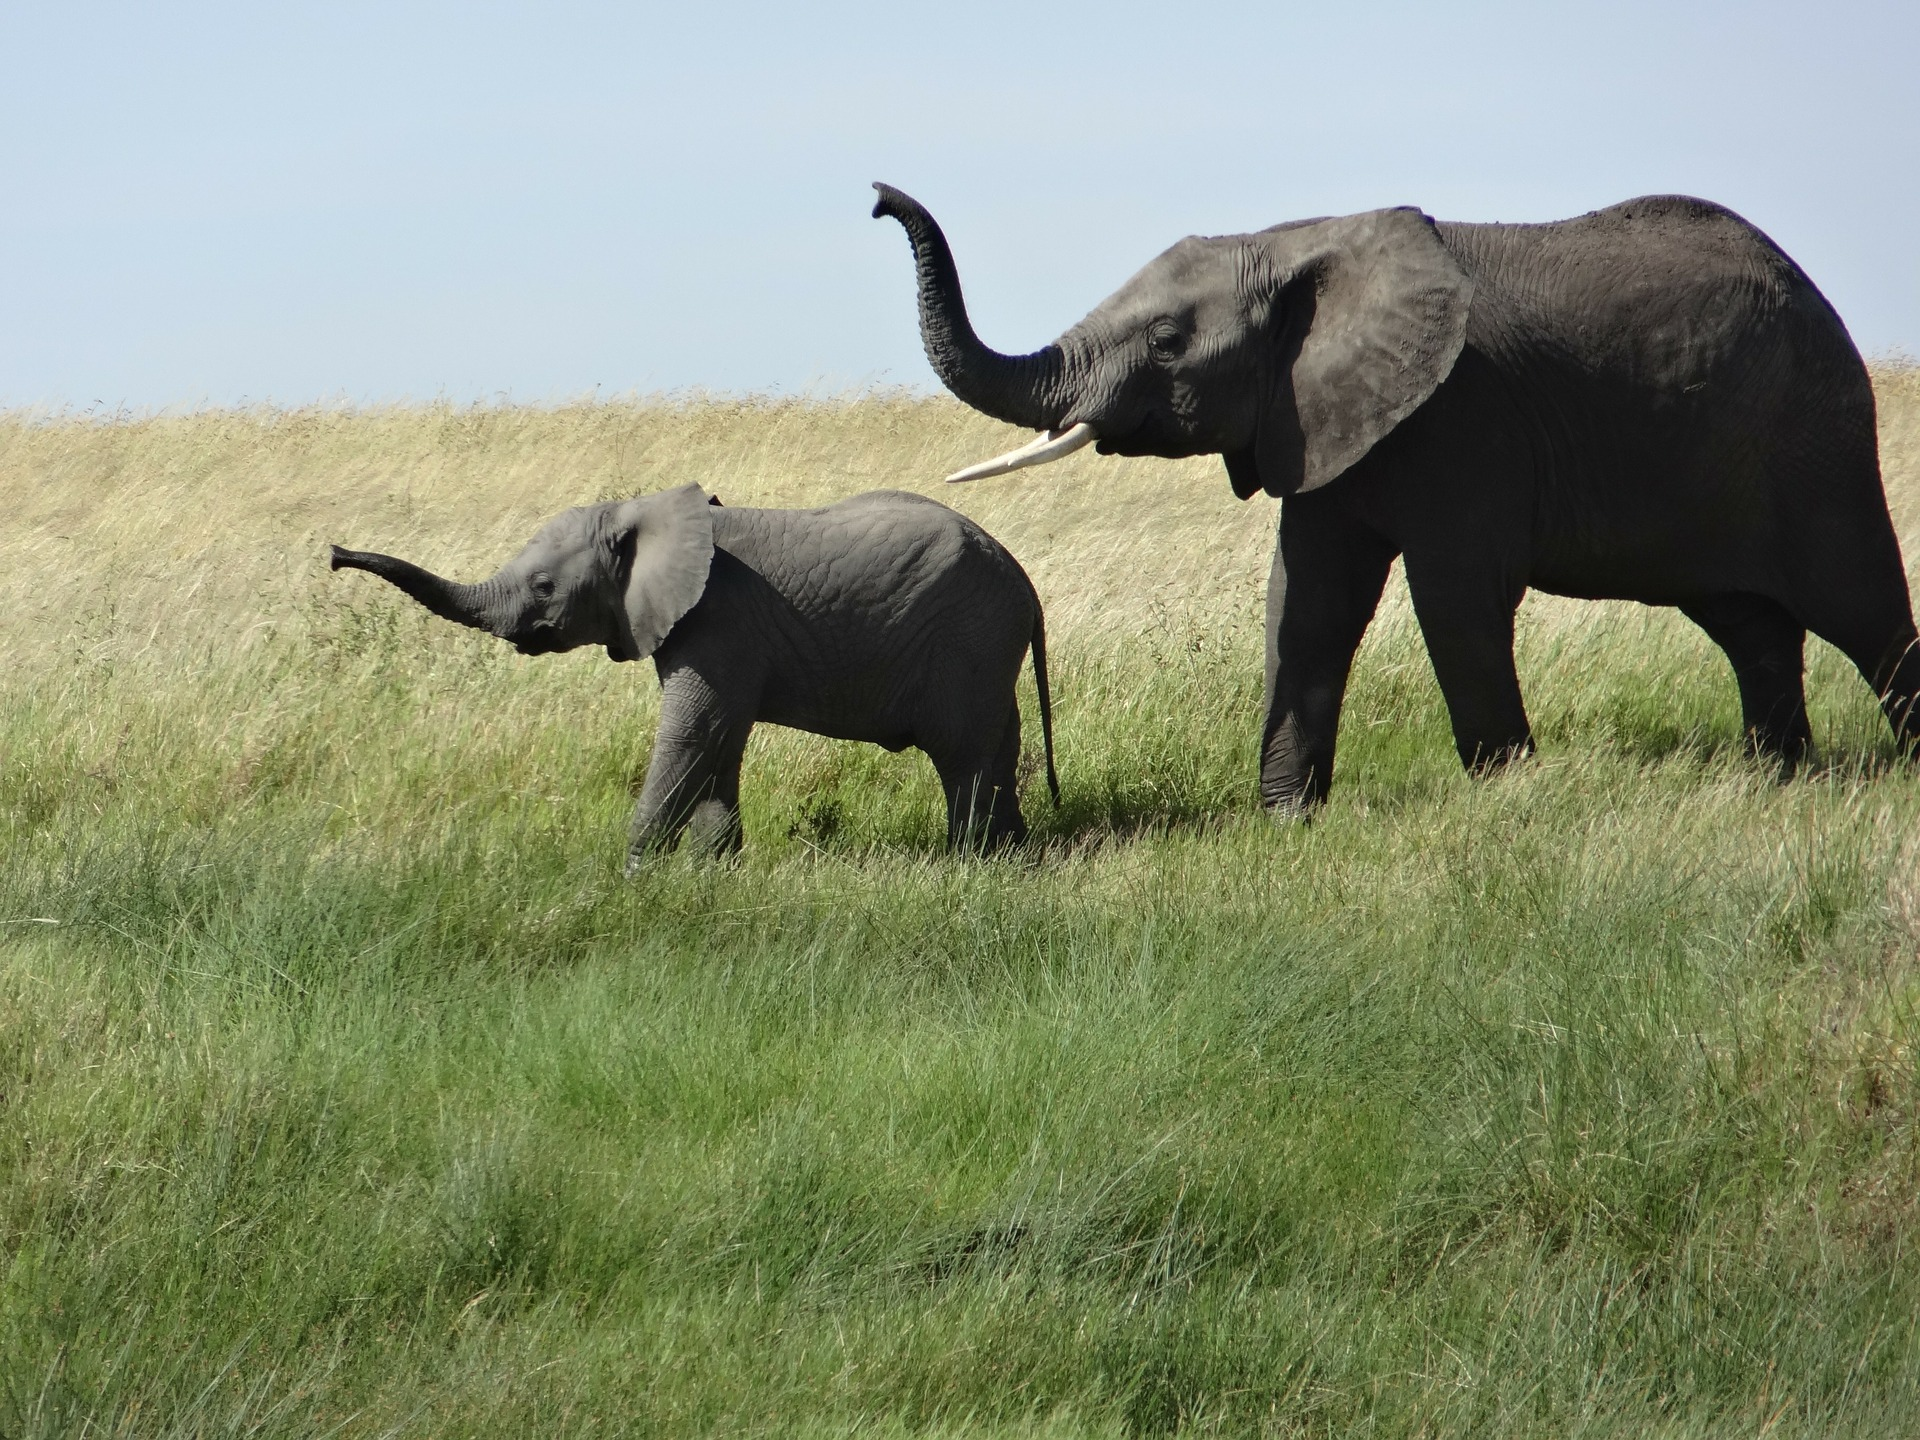

In [ ]:
display(Image(img_path))

#### Code following Listing 5.41

Run model on elephant picture

In [ ]:
preds = model.predict(img)
print('Predicted:', decode_predictions(preds, top=3)[0])
print(preds[:,386])

Predicted: [('n02504458', 'African_elephant', 0.88319594), ('n01871265', 'tusker', 0.10102216), ('n02408429', 'water_buffalo', 0.008600003)]
[0.88319594]


In [ ]:
np.argmax(preds[0])

386

### Listing 5.42

This is from Chollet's github repository.  Feel free to split your code up into multiple cells.  I found it useful to do this for debugging.

In [ ]:
# function 
def gradcam_heatmap(img, model, last_conv_layer_name, classifier_layer_names):
  # The is the output feature map of the `block5_conv3` layer,
  # the last convolutional layer in VGG16
  last_conv_layer = model.get_layer(last_conv_layer_name)
  last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

  # Second, we create a model that maps the activations of the last conv
  # layer to the final class predictions
  classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
  input = classifier_input
  for layer_name in classifier_layer_names:
    input = model.get_layer(layer_name)(input)
  classifier_model = tf.keras.Model(classifier_input, input)

  # This is the gradient of the "african elephant" class with regard to
  # the output feature map of `block5_conv3`
  with tf.GradientTape() as g_tape:
    # Compute activations of the last conv layer and make the tape watch it
    conv_layer_output_value = last_conv_layer_model(img)
    g_tape.watch(conv_layer_output_value)
    # Compute class predictions
    preds = classifier_model(conv_layer_output_value)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

  # This is the gradient of the top predicted class with regard to
  # the output feature map of the last conv layer
  grads = g_tape.gradient(top_class_channel, conv_layer_output_value)

  # This is a vector of shape (512,), where each entry
  # is the mean intensity of the gradient over a specific feature map channel
  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  # These are the values of these two quantities, as Numpy arrays,
  # given our sample image of two elephants
  conv_layer_output_value = conv_layer_output_value.numpy()[0]

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the elephant class
  for i in range(pooled_grads.shape[0]):
      conv_layer_output_value[:, :, i] *= pooled_grads[i]

  # The channel-wise mean of the resulting feature map
  # is our heatmap of class activation
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  return heatmap

heatmap = gradcam_heatmap(img, model, last_conv_layer_name, classifier_layer_names)

### Listing 5.43

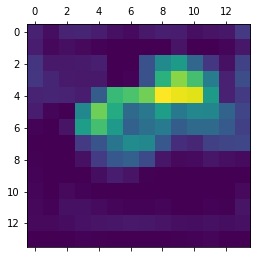

In [ ]:
# normalize the heatmap
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
plt.matshow(heatmap);

### Listing 5.44

In this case the whole listing was scrapped and the material 'Create a superimposed visualization' from the web code was used.

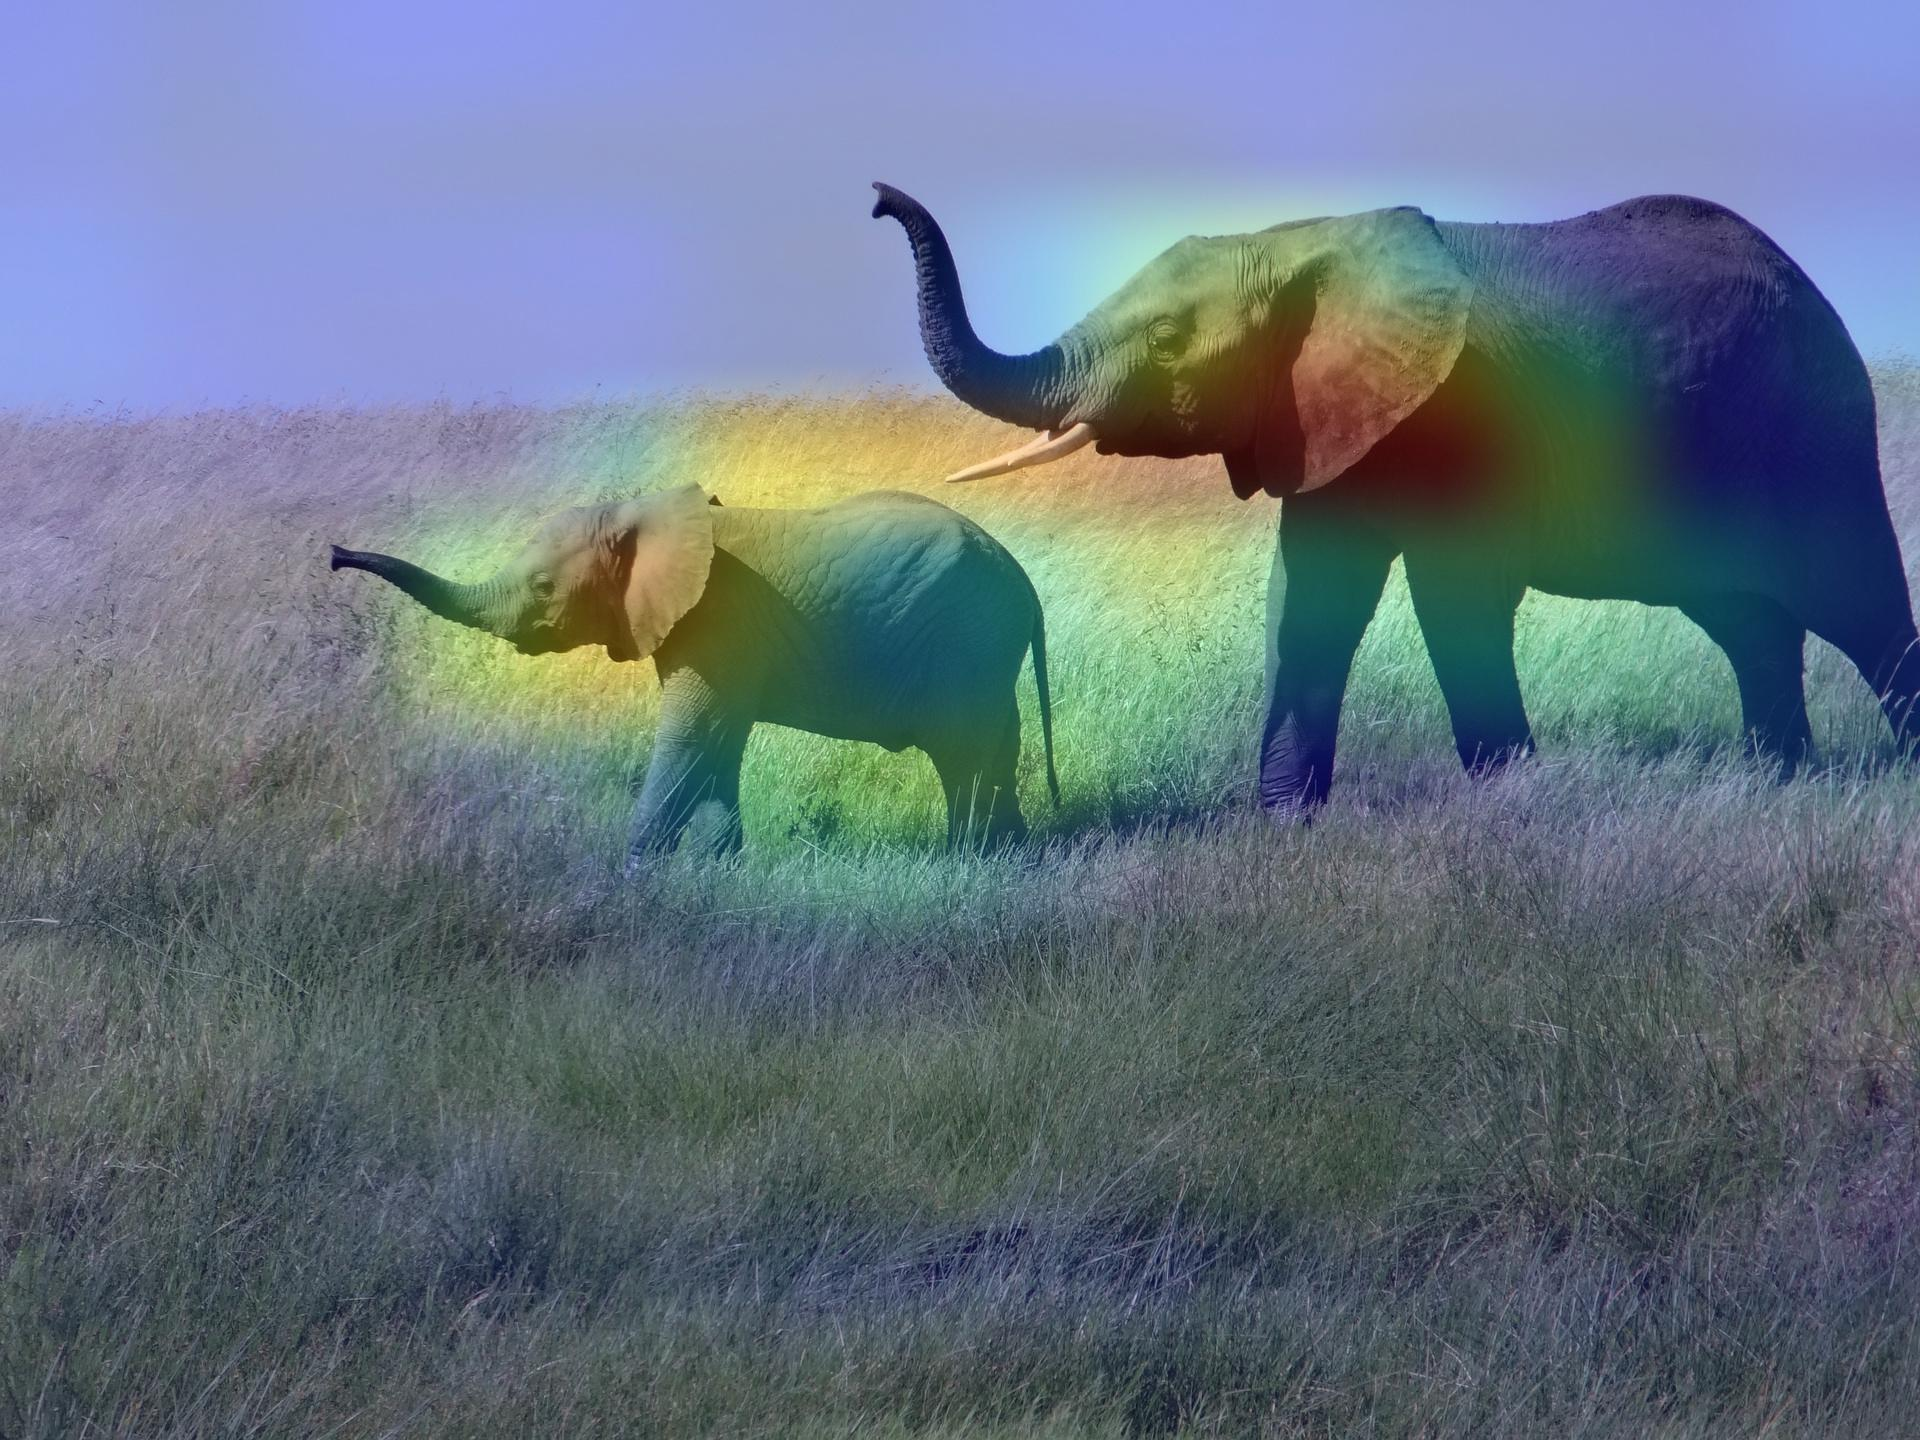

In [ ]:
# We load the original image
img = image.load_img(img_path)
img = image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

## Discussion

I had to go over the web code multiple times to grasp an idea on how it worked. The first thing that I read from the instructions is that K.gradients doesnt work when eager execution is on, so with more time spent reading the documention and trying to figure out how tf.GradientTape() works, I managed to make the code run. I had to remove some book code to make this work. I spend some time reading documentations and explanations on how grad-cam functions works. Its still a mystery to me how tf.GradientTape() worked, but reading from our grad-cam channel, Rosario and Joey gave their insight on it and I'm understanding it a bit better.

## Additional tests and experiments

See shape of VGG16 input.

In [ ]:
print(model.input)
print(model.inputs)

Tensor("input_1:0", shape=(None, 224, 224, 3), dtype=float32)
[<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>]


Get names of inception layers to understand example on web.

In [ ]:
emodel = Xception(weights='imagenet')
emodel.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

An experiment with early evaluation.  In Tensorflow 1 the tf.matmul() call would need to be made within a session.

In [ ]:
x = [[1.2]]
m = tf.matmul(x,x)

A comparison of K.mean() and tf.reduce_mean().
Both compute the mean, but K.mean() requires a tensor as input.

In [ ]:
a = np.array([[3.,4], [5.,6], [7.,8]])
b = K.constant(a)
print(K.mean(b))
print(tf.reduce_mean(a))

tf.Tensor(5.5, shape=(), dtype=float32)
tf.Tensor(5.5, shape=(), dtype=float64)


Lets try this with a different image.

In [ ]:
model = VGG16(weights='imagenet')

In [ ]:
# The local path to the target image
img_path = get_file(
    "dog.jpg", "https://i.imgur.com/FRK6meX.png"
)

img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = preprocess_input(x)

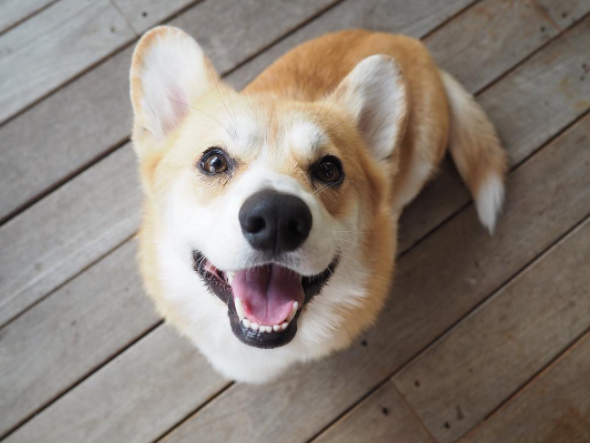

In [ ]:
display(Image(img_path))

This model predicted that its a Pembroke dog with 87% accuracy. It's interesting to see that it also predicted a Cardigan and a dingo.

In [ ]:
preds = model.predict(img)
print('Predicted:', decode_predictions(preds, top=3)[0])
print(preds[:,263])

Predicted: [('n02113023', 'Pembroke', 0.87286365), ('n02113186', 'Cardigan', 0.023569813), ('n02115641', 'dingo', 0.021177346)]
[0.87286365]


In [ ]:
heatmap = gradcam_heatmap(img, model, last_conv_layer_name, classifier_layer_names)

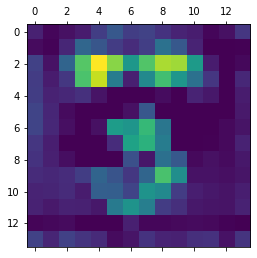

In [ ]:
# normalize the heatmap
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
plt.matshow(heatmap);

Its intereseting to see what the model picks as important features to identify what the picture is. It determined the ears, nose, and near the mouth since those areas are highlighted more in the heatmap.

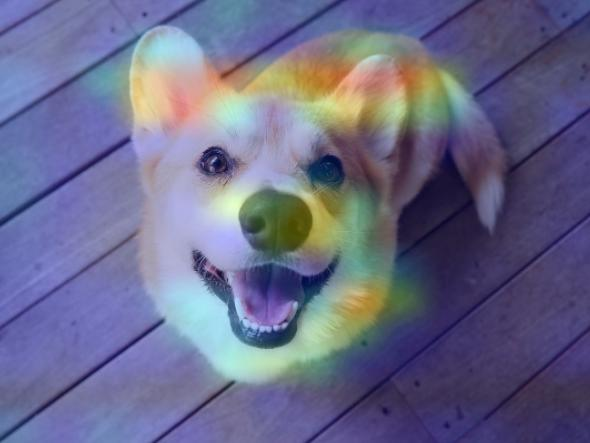

In [ ]:
img = image.load_img(img_path)
img = image.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")

jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = image.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = image.array_to_img(superimposed_img)

save_path = "dog_cam.jpg"
superimposed_img.save(save_path)

display(Image(save_path))

Lets try another interesting photo

In [ ]:
img_path = get_file(
    "sea_otters.jpg", "https://i.imgur.com/neVk7fi.jpg"
)

img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = preprocess_input(x)

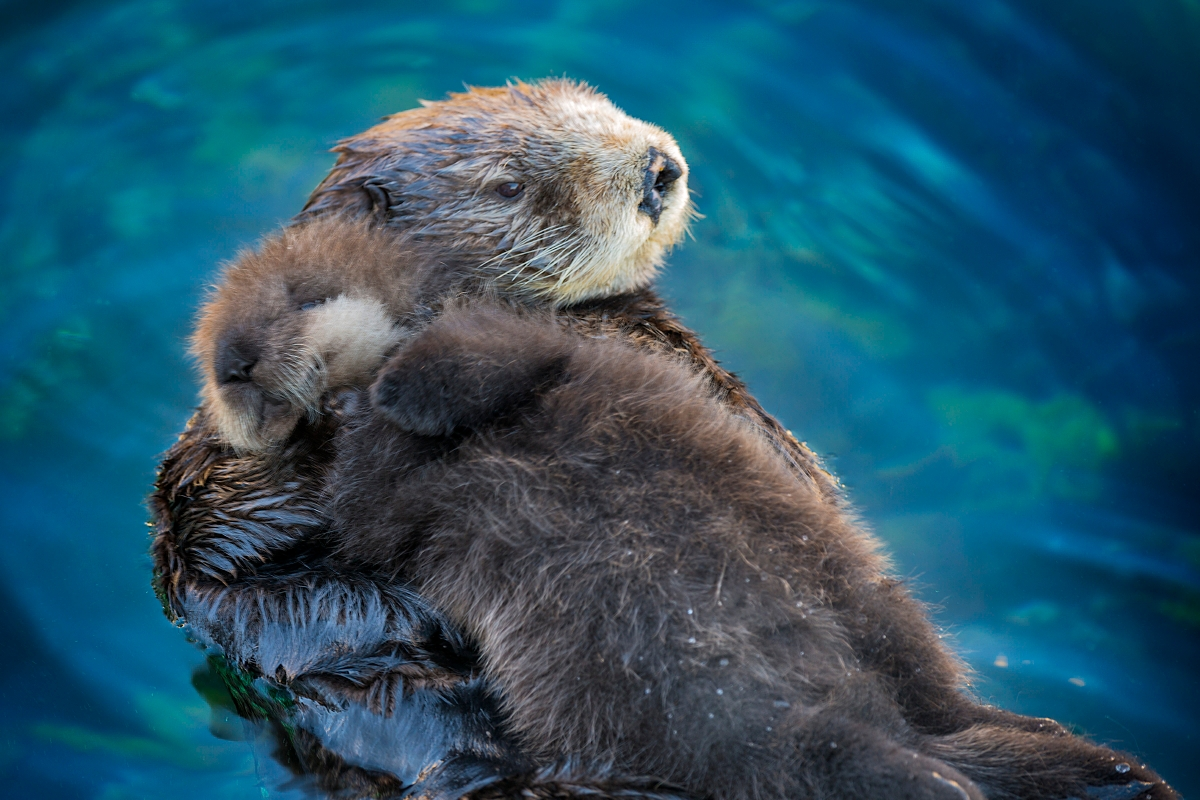

In [ ]:
display(Image(img_path))

In [ ]:
preds = model.predict(img)
print('Predicted:', decode_predictions(preds, top=3)[0])
print(preds[:,360])

Predicted: [('n02444819', 'otter', 0.80096126), ('n02363005', 'beaver', 0.17542677), ('n02361337', 'marmot', 0.015557587)]
[0.80096126]


In [ ]:
heatmap = gradcam_heatmap(img, model, last_conv_layer_name, classifier_layer_names)

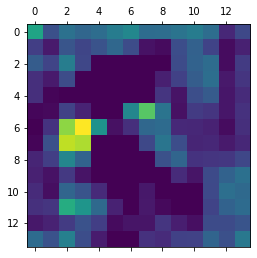

In [ ]:
# normalize the heatmap
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
plt.matshow(heatmap);

Its interesting to see the highlighted areas of the heatmap, the model determined on one of the otter's nose and the fluff to be important and predicted it to be otter with 80% accuracy

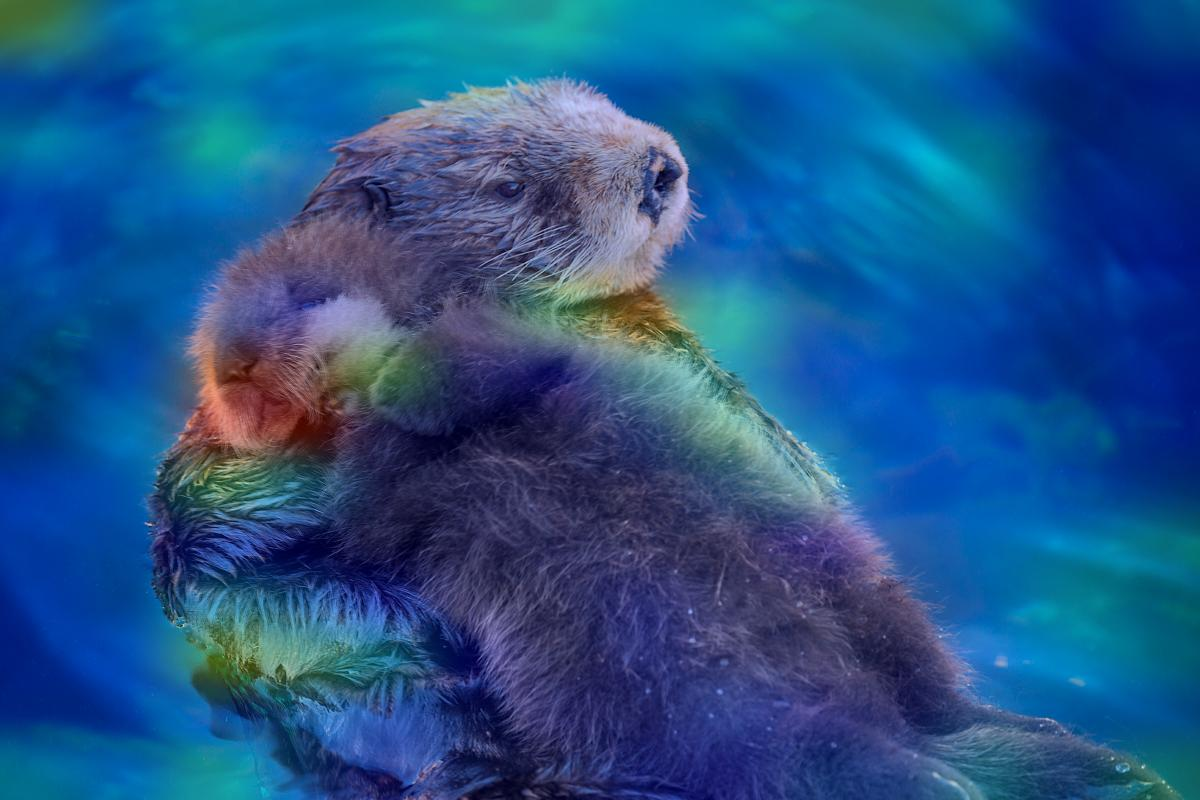

In [ ]:
img = image.load_img(img_path)
img = image.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")

jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = image.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = image.array_to_img(superimposed_img)

save_path = "otter_cam.jpg"
superimposed_img.save(save_path)

display(Image(save_path))

***Instead of chosing the last convulotional layer, lets pick a different layer.***

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

The layer that I used is block4_conv1, which looks like its the middle layer in the model. 


In [ ]:
conv_layer_name = 'block4_conv1'
classifier_layer_names = [
    'block4_conv2',
    'block4_conv3',
    # 'block4_pool',                     
    'block5_conv1',
    'block5_conv2',
    "block5_conv3",
    "block5_pool",
    "flatten",
    "fc1",
    "fc2",
    "predictions",
]

img_path = get_file(
    "african_elephant.jpg", " https://i.imgur.com/Bvro0YD.png"
)

img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = preprocess_input(x)

In [ ]:
heatmap = gradcam_heatmap(img, model, last_conv_layer_name, classifier_layer_names)

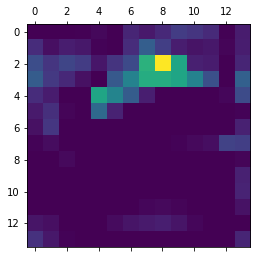

In [ ]:
# normalize the heatmap
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
plt.matshow(heatmap);

Its interesting to see that at this convolutional layer, the most important features to it is the top of the head of the bigger elephant. Compared to the last convolutional layer, we can see the last layer has a bigger area of highlighted features, while this layer (block4_conv1) seems to have highlighted features around the image.

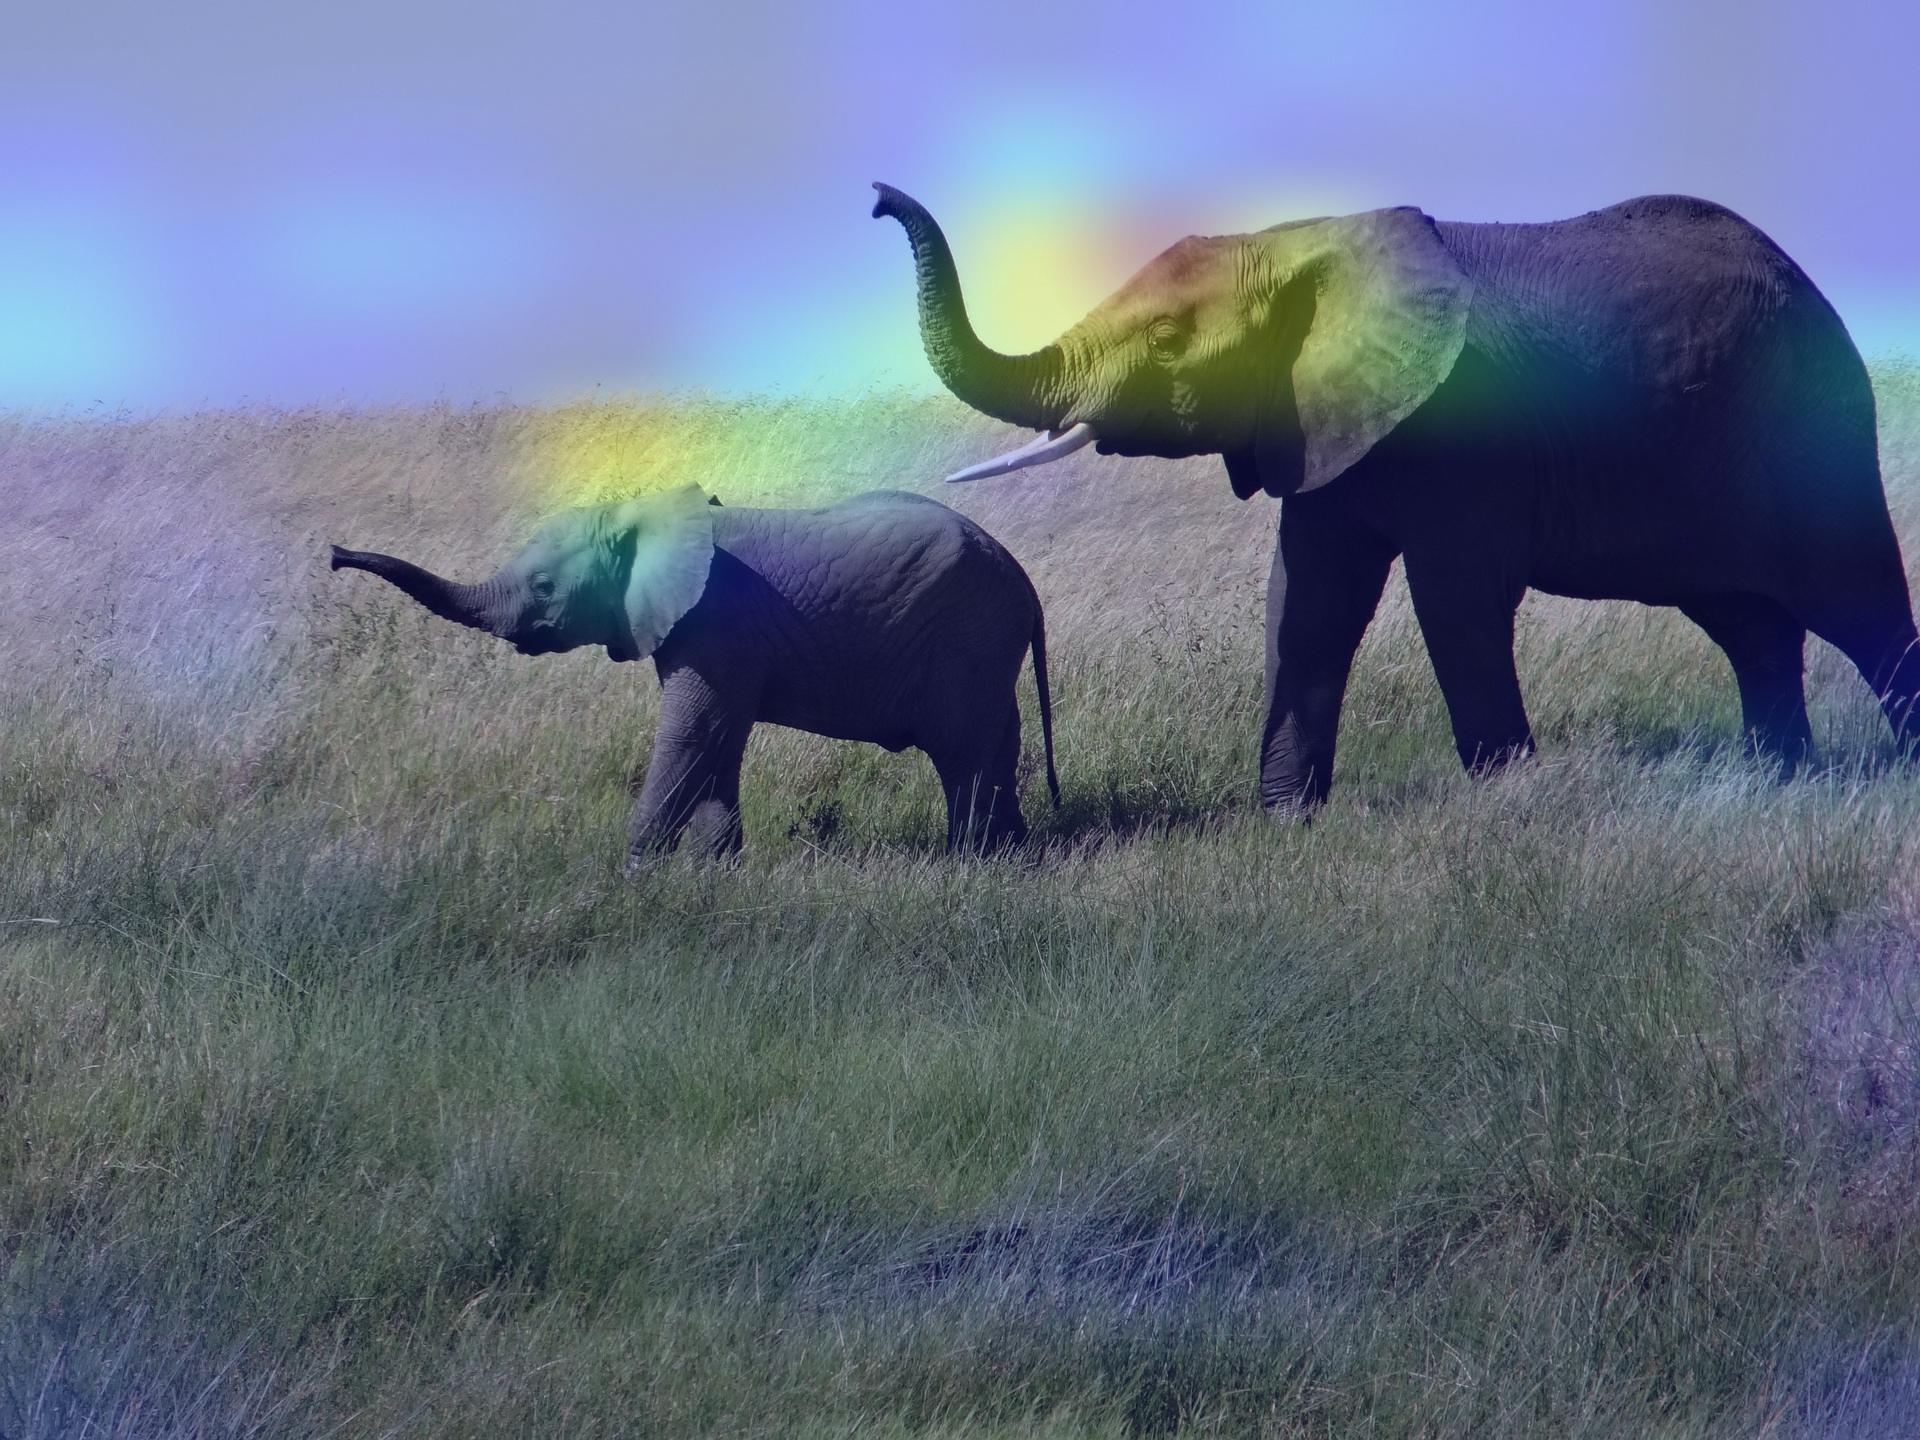

In [ ]:
# We load the original image
img = image.load_img(img_path)
img = image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "elephant2_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

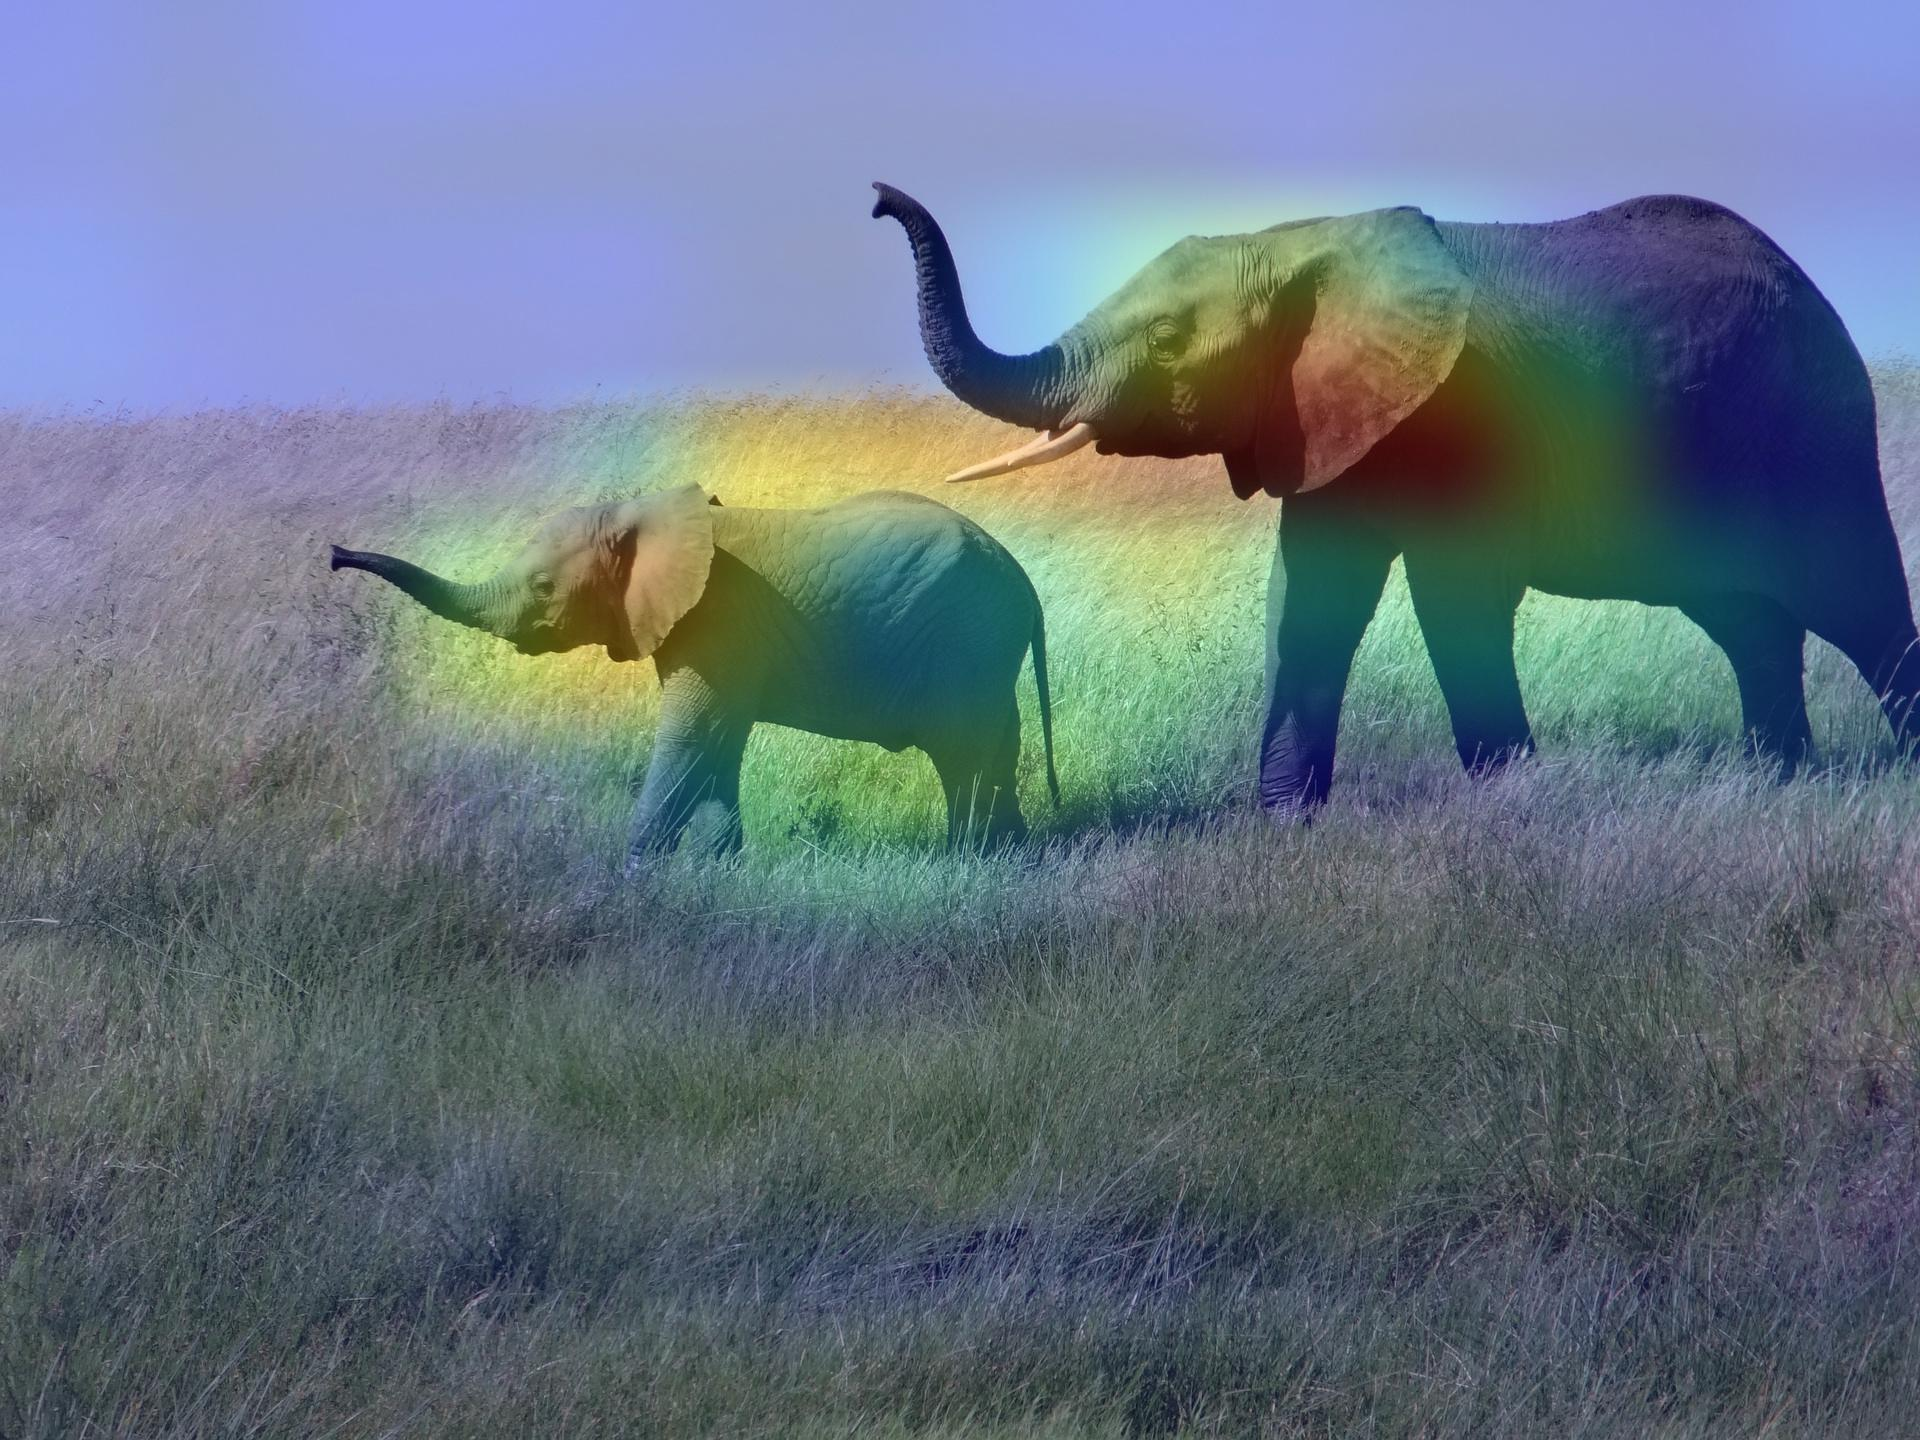

In [ ]:
display(Image('elephant_cam.jpg'))